# Preparing environment

## Importation

In [1]:
import os
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf

## Configuration

In [2]:
# Resizing
img_height = 32
img_width = 32
channels = 3
batch_size = 32
epochs = 20
color_mode='rgb'

dataset_path = "./chest_xray"
AUTOTUNE = tf.data.AUTOTUNE


## Functions 

In [3]:
# Function to show images
def show_images(class_names, dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()


# Function to normalize datasets
def normalize_dataset(dataset):
  normalize_layer = tf.keras.layers.Reshape(target_shape=(-1, img_width, img_height, channels))
  dataset = dataset.map(lambda x, y: (normalize_layer(x), y))
  normalize_layer = tf.keras.layers.Rescaling(1. / 255)
  return dataset.map(lambda x, y: (normalize_layer(x), y))



# Datasets environment

## Classification datasets

In [4]:
# Classifying train dataset in 3 labels
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    join(dataset_path, "train"),
    color_mode=color_mode,
    image_size=(img_height, img_width),
    batch_size=batch_size)

#train_ds = train_ds.astype('float32')
#train_ds = train_ds / 255.

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    join(dataset_path, "val"),
    color_mode=color_mode,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Classifying test dataset in 3 labels
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    join(dataset_path, "test"),
    color_mode=color_mode,
    image_size=(img_height, img_width),
    batch_size=batch_size)
#test_ds = test_ds.astype('float32')
#test_ds = test_ds / 255.

# Showing found labels
class_names = train_ds.class_names
nClasses = len(class_names)
print("Train classes", class_names)
print('Total number of outputs : ', nClasses)

print("Validation classes", validation_ds.class_names)
print('Total number of validation outputs : ', len(validation_ds.class_names))

print("Test classes", test_ds.class_names)
print('Total number of outputs : ', len(test_ds.class_names))

# Showing 10 images from de training set already resized
#show_images(class_names, train_ds)

Found 5216 files belonging to 3 classes.
Metal device set to: AMD Radeon Pro 560
Found 16 files belonging to 2 classes.
Found 624 files belonging to 3 classes.
Train classes ['NORMAL', 'PNEUMONIA BACTERIA', 'PNEUMONIA VIRUS']
Total number of outputs :  3
Validation classes ['NORMAL', 'PNEUMONIA BACTERIA']
Total number of validation outputs :  2
Test classes ['NORMAL', 'PNEUMONIA BACTERIA', 'PNEUMONIA VIRUS']
Total number of outputs :  3


2021-12-13 22:16:50.587842: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 22:16:50.588694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-13 22:16:50.588946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Normalizing datasets

In [5]:
# Normalizing training and test datasets
normalized_train_ds = normalize_dataset(train_ds)
normalized_validation_ds = normalize_dataset(validation_ds)
normalized_test_ds = normalize_dataset(test_ds)

# CNN Model

## Training the model

In [6]:
from tensorflow.keras import datasets, layers, models

# Defining the model
# model = models.Sequential()
# model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1))
#
# # Compiling the model
# model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
# model.summary()
#
# # Training the model
# #history = model.fit(train_ds, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=test_ds)
#

num_classes = len(class_names)

model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds,epochs=epochs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          3

2021-12-13 22:16:51.671298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.6262

2021-12-13 22:17:11.769630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 25s 142ms/step - loss: 0.8169 - accuracy: 0.6262 - val_loss: 0.8942 - val_accuracy: 0.6699
Epoch 2/20
163/163 [==============================] - 32s 190ms/step - loss: 0.5312 - accuracy: 0.7680 - val_loss: 0.7478 - val_accuracy: 0.7308
Epoch 3/20
163/163 [==============================] - 29s 168ms/step - loss: 0.4844 - accuracy: 0.7847 - val_loss: 1.1563 - val_accuracy: 0.6218
Epoch 4/20
163/163 [==============================] - 24s 138ms/step - loss: 0.4705 - accuracy: 0.7905 - val_loss: 1.1078 - val_accuracy: 0.6843
Epoch 5/20
163/163 [==============================] - 20s 116ms/step - loss: 0.4359 - accuracy: 0.8027 - val_loss: 1.0756 - val_accuracy: 0.6971
Epoch 6/20
163/163 [==============================] - 22s 129ms/step - loss: 0.4213 - accuracy: 0.8158 - val_loss: 1.2213 - val_accuracy: 0.6843
Epoch 7/20
163/163 [==============================] - 20s 116ms/step - loss: 0.4100 - accuracy: 0.8169 - val_loss: 1.4730 - val_accuracy: 0.6

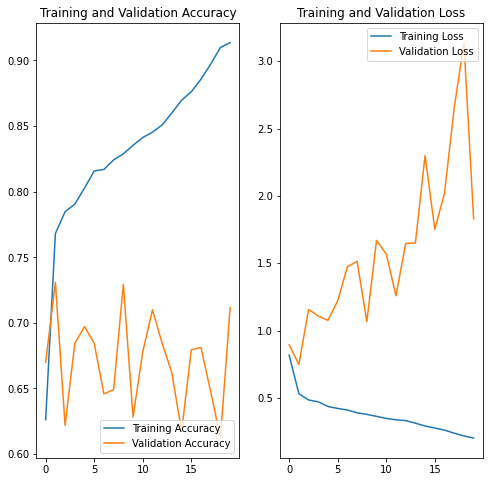

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.ylim([0, 1])
#plt.legend(loc='lower right')

In [8]:
# Los gráficos muestran que la precisión del entrenamiento y la precisión de la validación están fuera de lugar por grandes márgenes, y el modelo ha logrado solo alrededor del 60% de precisión en el conjunto de validación.

# Inspeccionemos qué salió mal e intentemos aumentar el rendimiento general del modelo.

## Evaluating test dataset


In [9]:
test_loss, test_acc = model.evaluate(validation_ds, verbose=2)

print(test_acc)


1/1 - 0s - loss: 1.0710 - accuracy: 0.6875 - 71ms/epoch - 71ms/step
0.6875


In [22]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, channels)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

def resize_and_rescale(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [img_width, img_height])
  image = (image / 255.0)
  return image

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  # return ds.prefetch(buffer_size=AUTOTUNE)
  return ds


#plt.figure(figsize=(10, 10))
#for images, _ in train_ds.take(1):
 # for i in range(9):
  #  augmented_images = data_augmentation(images)
   # ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(augmented_images[0].numpy().astype("uint8"))
    #plt.axis("off")

augmented_train_ds = prepare(train_ds, shuffle=True, augment=True)


In [25]:
# model = models.Sequential()
# #model.add(data_augmentation)
# model.add(layers.Rescaling(1./255))
# model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
# model.add(layers.MaxPooling2D())
# model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
# model.add(layers.MaxPooling2D())
# model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(layers.MaxPooling2D())
# model.add(layers.Dropout(0.2))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(num_classes))

model = models.Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [26]:
epochs = 15
history = model.fit(
  augmented_train_ds,
  validation_data=test_ds,
  epochs=epochs
)

InvalidArgumentError: Cannot assign a device for operation sequential_12/random_flip_7/stateful_uniform_full_int/RngReadAndSkip: Could not satisfy explicit device specification '' because the node {{colocation_node sequential_12/random_flip_7/stateful_uniform_full_int/RngReadAndSkip}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
RngReadAndSkip: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  sequential_12_random_flip_7_stateful_uniform_full_int_rngreadandskip_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  sequential_12/random_flip_7/stateful_uniform_full_int/RngReadAndSkip (RngReadAndSkip) 

	 [[{{node sequential_12/random_flip_7/stateful_uniform_full_int/RngReadAndSkip}}]] [Op:MakeIterator]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(validation_ds, verbose=2)

print(test_acc)


# Developing model for a web application

## Saving model

In [ ]:
import tempfile
import os

MODEL_DIR = os.path.join(dataset_path, "model")
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}')

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format='test.h5',
    signatures=None,
    options=None
)

print('Saved model:')
!ls -l {export_path}




